In [2]:
%load_ext autoreload
%autoreload 2
import loader
from feature_extractor import ImageFeatureExtractor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import os
import pandas as pd
import xgboost as xgb
import pandas as pd
import networkx as nx
import numpy as np
from itertools import combinations
from scipy.stats import spearmanr, kendalltau
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns



/home/dveduard/projects/noise-distribution-matching/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = {}
subsets = ['train', 'val', 'test']
for subset in subsets:
    data[subset] = loader.load_data(subset)

data['samples'] = loader.load_image_filenames()

# dataset_stats.display_pie_chart(data, 'subset_distribution.svg')
# dataset_stats.display_label_distribution(data['train'], 'train_label_dist.svg')
# dataset_stats.display_label_distribution(data['val'], 'train_label_dist.svg')
# dataset_stats.analyze_and_plot_histograms(data['samples'], 'filenames_distribution.svg')

In [4]:
def infer_new_pairs(df):
    df = df.copy()
    cols = ['id_noise_1', 'id_noise_2']
    df[cols] = np.sort(df[cols].values, axis=1)

    G = nx.Graph()
    label_1_df = df[df['label'] == 1]
    G.add_edges_from(label_1_df[cols].values)

    all_nodes = pd.unique(df[cols].values.ravel())
    G.add_nodes_from(all_nodes)

    components = list(nx.connected_components(G))
    id_to_group_idx = {node: i for i, comp in enumerate(components) for node in comp}

    new_rows = []
    for comp in components:
        if len(comp) > 1:
            for u, v in combinations(sorted(comp), 2):
                new_rows.append({'id_noise_1': u, 'id_noise_2': v, 'label': 1})

    label_0_df = df[df['label'] == 0]
    processed_comp_pairs = set()

    for _, row in label_0_df.iterrows():
        u, v = row['id_noise_1'], row['id_noise_2']
        g_u = id_to_group_idx[u]
        g_v = id_to_group_idx[v]

        comp_pair = tuple(sorted((g_u, g_v)))
        if comp_pair in processed_comp_pairs:
            continue
        processed_comp_pairs.add(comp_pair)

        for node_u in components[g_u]:
            for node_v in components[g_v]:
                pair = sorted((node_u, node_v))
                new_rows.append({'id_noise_1': pair[0], 'id_noise_2': pair[1], 'label': 0})

    inferred_df = pd.DataFrame(new_rows)
    final_df = pd.concat([df, inferred_df]).drop_duplicates(subset=['id_noise_1', 'id_noise_2'])

    return final_df.reset_index(drop=True)

data['train_boosted'] = infer_new_pairs(data['train'])
data['val_boosted'] = infer_new_pairs(data['val'])
data['official_train'] = infer_new_pairs(pd.concat([data['train'], data['val']]))

In [5]:
data['official_train']

,id_noise_1,id_noise_2,label
0,93095b95-90d0-40c0-962a-edf30e4df504,d4c96719-fdd8-4340-a9af-54977997393c,1
1,8cfb943e-6628-423f-83b6-446dfbf9f904,a32ae7ad-1ff0-4fd1-86eb-540e671d6e4c,1
2,0c06de5c-e414-4ee5-9bce-6cc2b9d9c116,11dae03e-4f1c-4e58-a259-8c15c6e32a12,0
3,5d85d41d-3574-46d2-b39a-e4c803c0b1f3,8c5c051e-a0c0-4000-96bb-6cb7beeeec00,1
4,61ca2130-a7b3-4dc6-a4e1-753b1962fedf,ab27169d-dd53-4964-a6c0-6e6d500e27c5,0
...,...,...,...
11812,02acb301-9864-438a-b6fa-265e6753176a,4b62490c-6861-4066-8745-62ae9b265871,0
11813,21d4fae7-d3c1-46e8-b694-4e07766e9923,5934799e-1fd1-4e8a-bf8c-8dbb1691512c,0
11814,1ee797f7-a9eb-4af2-a05f-ac79c1fe530b,cdb6cd22-7567-4170-bd04-4513af86ddfe,0
11815,7adbdd57-d4be-4140-8a5f-97d00ba56ff7,cc005436-d6a3-4b58-b8d2-afedb601e60e,0


In [6]:
extractor = ImageFeatureExtractor()
file_path = 'extracted_features.pkl'

if os.path.exists(file_path):
    print(f"Loading features from {file_path}...")
    data['features'] = pd.read_pickle(file_path)
else:
    print("File not found. Running feature extraction...")
    data['features'] = extractor.build_feature_dataframe(data['samples'])
    data['features'].to_pickle(file_path)
    print(f"Features saved to {file_path}.")

X_train, y_train = extractor.build_dataset(data['features'], data['train_boosted'])
X_val, y_val = extractor.build_dataset(data['features'], data['val'])
X_test, _ = extractor.build_dataset(data['features'], data['test'], type='test')
X_train_official, y_train_official = extractor.build_dataset(data['features'], data['official_train'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_official_scaled = scaler.transform(X_train_official)

Loading features from extracted_features.pkl...


8415it [01:02, 135.24it/s]
1800it [00:15, 119.21it/s]
4104it [00:17, 236.34it/s]
11817it [01:39, 118.98it/s]


In [7]:
def xgb_grid_search(param_grid, static_params, history_file):
    print(f"Starting Grid Search with {len(ParameterGrid(param_grid))} combinations...")

    for i, params in enumerate(ParameterGrid(param_grid)):
        print(f"\n Iteration {i+1} ")
        print(f"Testing params: {params}")

        current_params = {**static_params, **params}

        model = xgb.XGBClassifier(**current_params)

        model.fit(
            X_train_scaled, y_train,
            eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
            verbose=False
        )

        preds = model.predict(X_val_scaled)
        probs = model.predict_proba(X_val_scaled)[:, 1]
        val_acc = accuracy_score(y_val, preds)
        val_auc = roc_auc_score(y_val, probs)

        print(f"Result -> Accuracy: {val_acc:.4f} | AUC: {val_auc:.4f}")

        log_entry = current_params.copy()
        log_entry.update({
            'val_accuracy': val_acc,
            'val_auc': val_auc,
            'best_iteration': model.best_iteration,
            'best_score': model.best_score,
        })

        log_df = pd.DataFrame([log_entry])

        if not os.path.isfile(history_file):
            log_df.to_csv(history_file, index=False)
        else:
            log_df.to_csv(history_file, mode='a', header=False, index=False)

    print(f"\nGrid search complete. Results saved to {history_file}")

    results = pd.read_csv(history_file)
    best_run = results.loc[results['val_auc'].idxmax()]
    print("\nBest Parameters found by AUC:")
    print(best_run)


param_grid = {
    'learning_rate': [0.01, 0.02, 0.03],
    'max_depth': [6, 8, 10],
    'min_child_weight': [1],
    'subsample': [0.5],
    'colsample_bytree': [0.5, 0.6, 0.7,]
}

static_params = {
    'n_estimators': 1000,
    'early_stopping_rounds': 40,
    'n_jobs': -1,
    'eval_metric': 'logloss',
    'random_state': 42
}

history_file = 'grid_search_history.csv'
xgb_grid_search(param_grid, static_params, history_file)

Starting Grid Search with 27 combinations...

 Iteration 1 
Testing params: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.5}


KeyboardInterrupt: 

In [8]:
def train(params, X_train, y_train, X_val, y_val):
    print("Training XGBoost...")
    model = xgb.XGBClassifier(**params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=50
    )

    preds = model.predict(X_val)
    probs = model.predict_proba(X_val)[:, 1]

    val_acc = accuracy_score(y_val, preds)
    val_auc = roc_auc_score(y_val, probs)

    print(f"\nValidation Accuracy: {val_acc:.4f}")
    print(f"Validation AUC: {val_auc:.4f}")

    history_file = 'experiment_history.csv'

    log_entry = params.copy()
    log_entry.update({
        'val_accuracy': val_acc,
        'val_auc': val_auc,
        'best_iteration': model.best_iteration,
        'best_score': model.best_score,
    })

    log_df = pd.DataFrame([log_entry])

    if not os.path.isfile(history_file):
        log_df.to_csv(history_file, index=False)
    else:
        log_df.to_csv(history_file, mode='a', header=False, index=False)

    print(f"Results saved to {history_file}")
    return model



params = {
    'n_estimators': 2000,
    'learning_rate': 0.02,
    'max_depth': 8,
    'min_child_weight': 1,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'early_stopping_rounds': 100,
    'n_jobs': -1,
    'eval_metric': 'logloss',
    'random_state': 42
}
model = train(params, X_train_scaled, y_train, X_val_scaled, y_val)
official_model =  train(params, X_official_scaled, y_train_official, X_official_scaled, y_train_official)


Training XGBoost...
[0]	validation_0-logloss:0.64662	validation_1-logloss:0.71986
[50]	validation_0-logloss:0.42198	validation_1-logloss:0.56091
[100]	validation_0-logloss:0.32910	validation_1-logloss:0.49600
[150]	validation_0-logloss:0.27858	validation_1-logloss:0.46518
[200]	validation_0-logloss:0.24667	validation_1-logloss:0.44555
[250]	validation_0-logloss:0.22107	validation_1-logloss:0.43193
[300]	validation_0-logloss:0.20075	validation_1-logloss:0.42258
[350]	validation_0-logloss:0.18204	validation_1-logloss:0.41342
[400]	validation_0-logloss:0.16517	validation_1-logloss:0.40682
[450]	validation_0-logloss:0.15156	validation_1-logloss:0.40179
[500]	validation_0-logloss:0.13834	validation_1-logloss:0.39712
[550]	validation_0-logloss:0.12577	validation_1-logloss:0.39259
[600]	validation_0-logloss:0.11447	validation_1-logloss:0.38974
[650]	validation_0-logloss:0.10505	validation_1-logloss:0.38693
[700]	validation_0-logloss:0.09609	validation_1-logloss:0.38526
[750]	validation_0-logl

In [ ]:
model.feature_importances_


### Validation Performance Report ###


/tmp/ipykernel_13854/619384952.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['MAE', 'MSE'], y=[mae, mse], palette="Reds")
/tmp/ipykernel_13854/619384952.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Spearman', 'Kendall'], y=[spearman_corr, kendall_corr], palette="Greens")


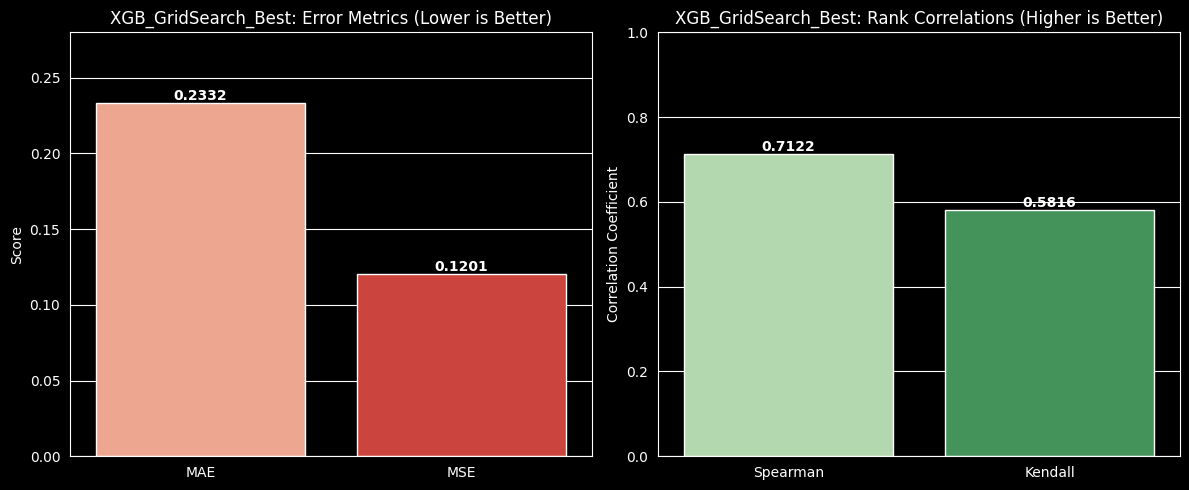

In [9]:
def validate_extended_metrics(model, X_val, y_val, model_name, filename):
    probs = model.predict_proba(X_val)[:, 1]

    mae = mean_absolute_error(y_val, probs)
    mse = mean_squared_error(y_val, probs)

    spearman_corr, _ = spearmanr(y_val, probs)
    kendall_corr, _ = kendalltau(y_val, probs)

    results = {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'Spearman_R': spearman_corr,
        'Kendall_Tau': kendall_corr
    }

    df_results = pd.DataFrame([results])

    print("\n### Validation Performance Report ###")


    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.barplot(x=['MAE', 'MSE'], y=[mae, mse], palette="Reds")
    plt.title(f"{model_name}: Error Metrics (Lower is Better)")
    plt.ylabel("Score")
    plt.ylim(0, max(mae, mse) * 1.2)
    for i, v in enumerate([mae, mse]):
        plt.text(i, v, f"{v:.4f}", ha='center', va='bottom', fontweight='bold')

    plt.subplot(1, 2, 2)
    sns.barplot(x=['Spearman', 'Kendall'], y=[spearman_corr, kendall_corr], palette="Greens")
    plt.title(f"{model_name}: Rank Correlations (Higher is Better)")
    plt.ylabel("Correlation Coefficient")
    plt.ylim(0, 1.0)
    for i, v in enumerate([spearman_corr, kendall_corr]):
        plt.text(i, v, f"{v:.4f}", ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

    return df_results

performance_df = validate_extended_metrics(model, X_val_scaled, y_val, model_name="XGB_GridSearch_Best", filename="xgboost-results.svg")

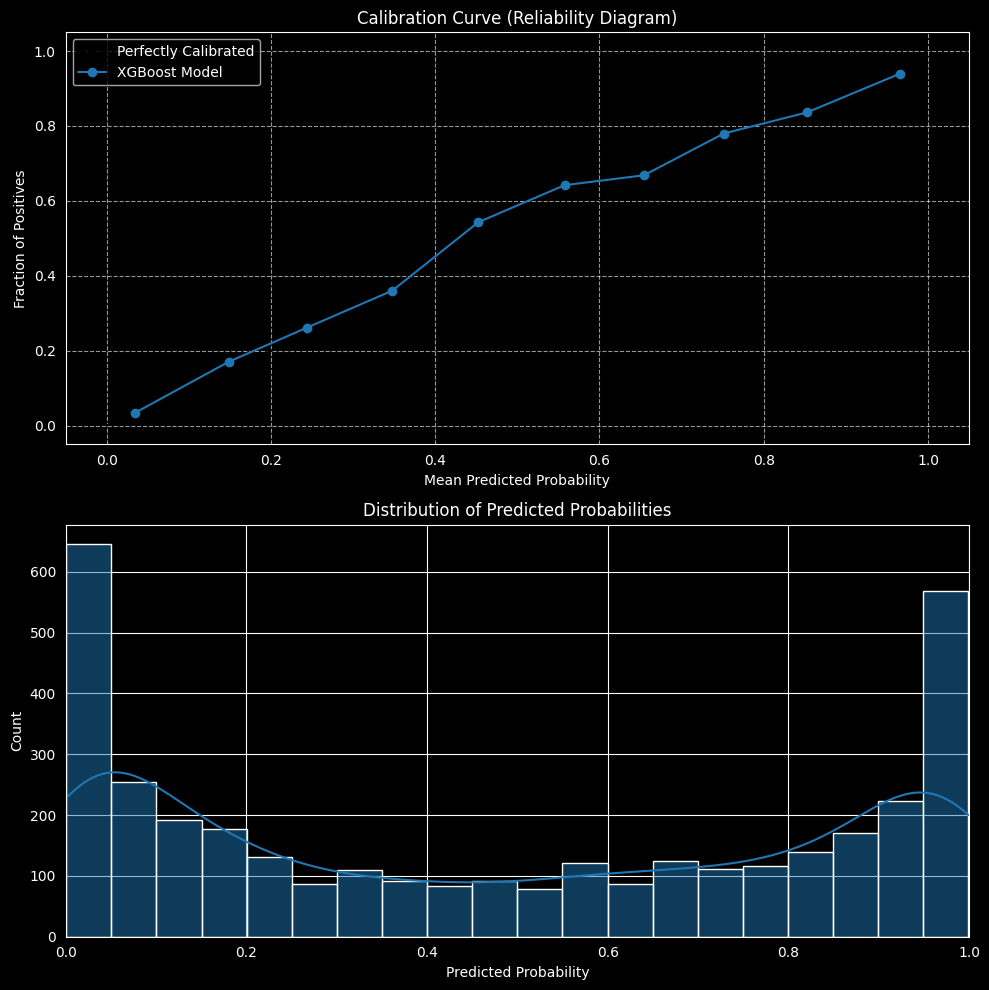

In [10]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import seaborn as sns

def plot_calibration_curve(model, X_val, y_val, n_bins=10, filename="temp"):
    probs = model.predict_proba(X_val)[:, 1]
    prob_true, prob_pred = calibration_curve(y_val, probs, n_bins=n_bins, strategy='uniform')

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='black')
    plt.plot(prob_pred, prob_true, marker='o', label='XGBoost Model', color='tab:blue')

    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Curve (Reliability Diagram)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.subplot(2, 1, 2)
    sns.histplot(probs, bins=20, kde=True, color='tab:blue', alpha=0.5)
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")
    plt.title("Distribution of Predicted Probabilities")
    plt.xlim(0, 1)

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_calibration_curve(model, X_val_scaled, y_val, filename="calibration.svg")

In [11]:
def run_inference(model, model2, test_df, X, output_file='submission.csv'):
    predictions = model.predict(X)
    # predictions2 = model2.predict(X)

    submission_df = pd.DataFrame({
        'id_pair': '(' + test_df['id_noise_1'].astype(str) + ',' + test_df['id_noise_2'].astype(str) + ')',
        'label': predictions,
        # 'label2': predictions2
    })

    submission_df.to_csv(output_file, index=False)

    print(f"Results saved to {output_file}")
    print(submission_df.head())
    return submission_df

run_inference(official_model, official_model, data['test'], X_test_scaled)

Success! Results saved to submission.csv

Preview:
                                             id_pair  label
0  (f7e83d94-04ec-4132-83c2-74079ef09bbb,245d3dae...      1
1  (bda1bca4-ba7e-4491-bcdf-b06da6a22797,c31c1dc6...      1
2  (98cd04bb-765d-474d-9aac-11cd08031408,39499584...      1
3  (d408511c-c297-4685-b5e5-91678487558f,5798eba2...      1
4  (06f5d59d-9554-4456-a705-efbba3b2d28e,49e7b081...      0


,id_pair,label
0,"(f7e83d94-04ec-4132-83c2-74079ef09bbb,245d3dae...",1
1,"(bda1bca4-ba7e-4491-bcdf-b06da6a22797,c31c1dc6...",1
2,"(98cd04bb-765d-474d-9aac-11cd08031408,39499584...",1
3,"(d408511c-c297-4685-b5e5-91678487558f,5798eba2...",1
4,"(06f5d59d-9554-4456-a705-efbba3b2d28e,49e7b081...",0
...,...,...
4099,"(47ea41d2-726f-4fcb-9fa9-8b793d884c06,f12bea4b...",1
4100,"(ab08cff1-7260-4928-8449-3e2f0064f020,f3ef389e...",1
4101,"(19fb6d22-57f2-4a62-8f6b-48760da1ca4c,cf379bdc...",1
4102,"(06ddf976-92fb-475c-aa60-8819aa29d24f,1f69012b...",1
